In [1]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
import six
from sklearn.metrics import roc_curve
import datetime
%matplotlib inline

In [2]:
#ecgData = np.load("./inData/3D-conv/ecgData.npy")
#ecgClass = np.load("./inData/3D-conv/ecgClass.npy")
unseenData = np.load("./inData/3D-conv/unseenData.npy")
unseenClass = np.load("./inData/3D-conv/unseenClass.npy")

In [3]:
def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

#ecgData = ecgData[..., np.newaxis]
unseenData = unseenData[..., np.newaxis]
#ecgClassOH = processClassData(ecgClass)
unseenClassOH = processClassData(unseenClass)

# Neural Network

In [5]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# Input layer:
net = tflearn.layers.core.input_data(shape=[None, 50, 19, 17, 1])

# First layer:
net = tflearn.layers.conv.conv_3d(net, 16, [2,5,5],  activation="leaky_relu")
net = tflearn.layers.conv.max_pool_3d(net, 2)

# Second layer:
net = tflearn.layers.conv.conv_3d(net, 32, [2,5,5], activation="leaky_relu")
net = tflearn.layers.conv.max_pool_3d(net, 2)

# Fully connected layer
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

# Dropout layer:
net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', learning_rate=0.0001, loss='categorical_crossentropy')

model = tflearn.DNN(net, tensorboard_verbose=0)
#model.fit(ecgData[:,::40], ecgClassOH, batch_size=8, n_epoch=10, show_metric=True)

In [ ]:
#model.save("./outData/models/3d_conv.tflearn")
model.load("./outData/models/3d_conv.tflearn")

In [15]:
def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

iUnseen, hUnseen = splitData(unseenData, unseenClass)
unseenHL = np.tile([1,0], (len(hUnseen), 1))
unseenIL = np.tile([0,1], (len(iUnseen), 1))
iUnseen = np.reshape(iUnseen, (-1,2000,19,17,1))
hUnseen = np.reshape(hUnseen, (-1,2000,19,17,1))

print(model.evaluate(unseenData[:,::40], unseenClassOH),"\n",\
    model.evaluate(np.array(iUnseen)[:,::40], unseenIL),"\n",\
    model.evaluate(np.array(hUnseen)[:,::40], unseenHL))

(2000, 19, 17, 1)
(20, 2000, 19, 17, 1)


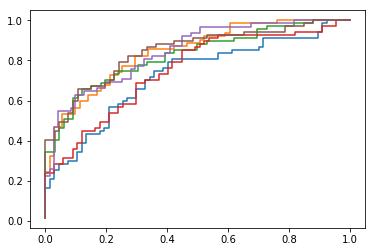

In [72]:
# Get ROC curve
if k == 1:
    predicted = np.array(model.predict(np.array(unseenData)[:,::40]))
    fpr, tpr, th = roc_curve(unseenClass, predicted[:,1])
    plt.plot(fpr,tpr)